In [10]:
def train_and_evaluate_model(model, model_name):
    if model_name == "LightGBM":
        model = model.train(params, lgb_train, valid_sets=[lgb_train, lgb_val])
    elif model_name == "CatBoost":
        model.fit(X_train_scaled, y_train,
                  eval_set=(X_val_scaled, y_val),
                  use_best_model=True,
                  logging_level='Silent')
    else:
        model.fit(X_train_scaled, y_train)


    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)

    def compute_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        return rmse, mae, r2

    rmse_train, mae_train, r2_train = compute_metrics(y_train, y_train_pred)
    rmse_val,   mae_val,   r2_val   = compute_metrics(y_val,   y_val_pred)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Rzeczywiste wartości')
    plt.ylabel('Przewidywane wartości')
    plt.title(f'{model_name} — Predicted vs. True Values')
    plt.grid(True)
    plt.show()


    print(f"--- {model_name} ---")
    print(f"TRAIN →  RMSE: {rmse_train:.4f} | MAE: {mae_train:.4f} | R²: {r2_train:.4f}")
    print(f"VALID →  RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | R²: {r2_val:.4f}")

    return {
        "rmse_train": rmse_train,
        "mae_train":  mae_train,
        "r2_train":   r2_train,
        "rmse_val":   rmse_val,
        "mae_val":    mae_val,
        "r2_val":     r2_val
    }


In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, Dataset as LGBDataset
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
train_cleaned= pd.read_csv('data/train_cleaned.csv')
val_cleaned   = pd.read_csv('data/val_cleaned.csv')

In [4]:
X_train = train_cleaned.iloc[:, :-1]
y_train = train_cleaned.iloc[:, -1]

X_val = val_cleaned.iloc[:, :-1]
y_val = val_cleaned.iloc[:, -1]

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled  = scaler.transform(X_val)

# Standaryzacja (Normalizacja zmiennych)

**Standaryzujemy (normalizujemy) zmienne**, ponieważ występują one w **różnych jednostkach i mają bardzo różne zakresy wartości** – bez tego dana o dużej skali mogłaby **zdominować obliczenia** kosztem cech o **mniejszej skali**.

Dzięki standaryzacji, czyli przekształceniu każdej cechy do rozkładu o **średniej 0 i odchyleniu standardowym 1**, zapewniamy, że algorytmy uczące się (zwłaszcza oparte na odległościach lub wykorzystujące regularyzację) traktują **wszystkie cechy równorzędnie**.

Ponadto wiele metod optymalizacji, np. algorytm gradientu prostego, zbiega szybciej i stabilniej na danych o **ujednoliconej skali**, co przekłada się na **efektywniejsze trenowanie modelu**.


# Metryki używane w ocenie modeli:
### **RMSE (Root Mean Squared Error)**  
Miara błędu, która uwzględnia kwadrat różnicy między wartościami rzeczywistymi a przewidywanymi.

Wzór:  

$$\boxed{\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}}$$
 
**Objaśnienie**:  
- $( y_i )$: wartość rzeczywista dla $( i )$-tej obserwacji,  
- $( \hat{y}_i )$: wartość przewidywana przez model dla $( i )$-tej obserwacji,  
- $( n )$: liczba obserwacji.  

---

### **MAE (Mean Absolute Error)**  
Średnia wartość bezwzględna różnicy między wartościami rzeczywistymi a przewidywanymi.

Wzór:  

$$\boxed{\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|}$$
  
**Objaśnienie**:  
- $( |y_i - \hat{y}_i| )$: bezwzględna różnica między wartością rzeczywistą a przewidywaną.  

---

### **R² (R-squared)**  
Wskaźnik dopasowania modelu; wartość bliska 1 oznacza bardzo dobre dopasowanie.

Wzór:  

$$\boxed{R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}}$$
 
**Objaśnienie**:  
- $( \bar{y} )$: średnia wartość zmiennej docelowej $( y )$,  
- Licznik: suma kwadratów reszt (różnic między wartościami rzeczywistymi a przewidywanymi),  
- Mianownik: całkowita suma kwadratów (różnic między wartościami rzeczywistymi a ich średnią).  

---

### Podsumowanie:  
* **RMSE** karze większe błędy (bo kwadratuje różnice), co jest przydatne, gdy duże błędy są szczególnie niepożądane.  
* **MAE** jest bardziej odporny na wartości odstające, ponieważ używa wartości bezwzględnych.  
* **R²** interpretuje się jako **procent wyjaśnionej wariancji** przez model. Im bliżej **1**, tym lepiej model pasuje do danych.  

<div style="page-break-before: always;"></div>

# Model Random Forest Regressor

**Random Forest Regressor** (Las losowy dla regresji) to **zespołowy algorytm uczenia nadzorowanego**, który buduje wiele drzew decyzyjnych i łączy ich przewidywania, aby uzyskać bardziej stabilne i dokładne wyniki. Jest wykorzystywany do przewidywania **wartości ciągłych**.

---

### **Jak działa?**  
1. **Tworzenie wielu drzew decyzyjnych**:  
   - Każde drzewo jest trenowane na **losowej podpróbie danych** (tzw. **bootstrapping** — próbkowanie ze zwracaniem).  
   - W każdym węźle drzewa wybierany jest **losowy podzbiór cech** do podziału (np. 30% wszystkich cech).  

2. **Predykcja**:  
   - Każde drzewo w lesie generuje własną prognozę.  
   - **Końcowy wynik** to **średnia arytmetyczna** wszystkich przewidywań poszczególnych drzew.

---

### **Kluczowe elementy**:  
* **Bootstrapping**:  
  Każde drzewo uczy się na innej losowej próbce danych (mogą wystąpić powtórzenia obserwacji).  
* **Losowy wybór cech**:  
  W każdym węźle drzewa algorytm wybiera podzbiór cech, co redukuje korelację między drzewami i zapobiega przetrenowaniu.  
* **Aggregacja (bagging)**:  
  Wyniki drzew są łączone, aby zmniejszyć wariancję modelu.

---

### **Zalety**:  
1. **Odporność na przetrenowanie**: Dzięki losowości i agregacji, model jest mniej podatny na overfitting niż pojedyncze drzewo.  
2. **Obsługa danych nieliniowych**: Skutecznie modeluje złożone zależności między cechami a zmienną docelową.  
3. **Automatyczna selekcja cech**: Pomija nieistotne cechy w procesie losowego wyboru.  
4. **Interpretowalność**: Możliwość oceny ważności cech (tzw. **feature importance**).  

---

### **Wady**:  
1. **Wolniejsze działanie**: Budowa wielu drzew zwiększa czas obliczeń.  
2. **Mniejsza interpretowalność niż pojedyncze drzewo**: Trudniej prześledzić logikę całego lasu.  
3. **Wrażliwość na szum**: Jeśli dane zawierają dużo losowego szumu, model może być mniej dokładny.  

---

### **Hiperparametry do strojenia**:  
* `n_estimators`: Liczba drzew w lesie (np. 100, 200).  
* `max_depth`: Maksymalna głębokość pojedynczego drzewa.  
* `min_samples_split`: Minimalna liczba próbek wymagana do podziału węzła.  
* `max_features`: Liczba/losowy podzbiór cech branych pod uwagę w każdym węźle. 

---

### **Podsumowanie**:  
Random Forest Regressor to **potężne narzędzie do regresji**, które łączy prostotę drzew decyzyjnych z siłą ensemble learningu. Sprawdza się zwłaszcza w problemach z dużą liczbą cech lub złożonymi zależnościami w danych.

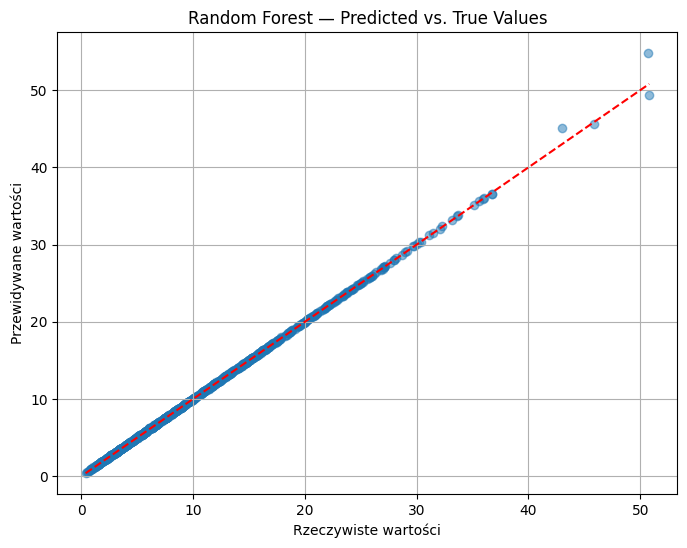

--- Random Forest ---
TRAIN →  RMSE: 0.0649 | MAE: 0.0057 | R²: 0.9999
VALID →  RMSE: 0.1628 | MAE: 0.0201 | R²: 0.9995


In [11]:
rf = RandomForestRegressor(random_state=42)
rmse_rf = train_and_evaluate_model(rf, "Random Forest")

### **Interpretacja wykresu**  

- Punkty są bardzo blisko linii **y = x**, co wskazuje na **wyjątkowo wysoką dokładność modelu**.  
- Niewielkie odchylenia od linii idealnej są widoczne tylko w powiększeniu (ze względu na małe wartości błędów).  
---

### **Podsumowanie**:  
* **Model jest bardzo dokładny**:  
   - Zarówno na zbiorze treningowym, jak i walidacyjnym, błędy (RMSE, MAE) są **bliskie zeru**, a R² **bliskie 1**.  
   - Świadczy to o tym, że model doskonale uchwycił zależności w danych.  

* **Brak oznak przetrenowania**:  
   - Różnica między wynikami TRAIN i VALID jest minimalna, co sugeruje, że model nie wykazuje oznak **przetrenwania**.  


<div style="page-break-before: always;"></div>

# Model XGBoostRegressor

**XGBRegressor** (eXtreme Gradient Boosting Regressor) to zaawansowana implementacja **gradient boostingu**, zaprojektowana do przewidywania wartości ciągłych. Jest częścią biblioteki **XGBoost**, która słynie z wydajności i skuteczności w konkursach data science (np. Kaggle).

---

### **Jak działa?**  
1. **Gradient Boosting**:  
   - Algorytm buduje **sekwencję słabych modeli** (zwykle drzew decyzyjnych), gdzie każdy kolejny model koryguje błędy poprzedniego.  
   - W każdej iteracji obliczane są **reszty** (różnice między przewidywaniami a wartościami rzeczywistymi), a nowe drzewo uczy się je minimalizować.  

2. **Funkcja straty i optymalizacja**:  
   - XGBRegressor minimalizuje **funkcję straty** (np. MSE – błąd średniokwadratowy) za pomocą gradientu (pochodnej funkcji straty).  
   - Stosuje **optymalizację drugiego rzędu** (uwzględnia również drugą pochodną), co przyspiesza zbieżność.  

3. **Regularyzacja**:  
   - Dodaje kary za zbyt skomplikowane modele (np. za dużą liczbę liści w drzewach), aby zapobiec przetrenowaniu.  
   - Parametry `lambda` (L2) i `alpha` (L1) kontrolują siłę regularyzacji.  

---

### **Kluczowe cechy XGBRegressor**:  
1. **Wydajność**:  
   - Optymalizacja pod kątem szybkości (wykorzystanie równoległych obliczeń, cache’owania danych).  
2. **Obsługa brakujących wartości**:  
   - Automatycznie radzi sobie z brakującymi danymi, wybierając optymalne kierunki podziału w drzewach.  
3. **Elastyczność**:  
   - Może używać różnych funkcji straty i metryk ewaluacji.  
4. **Ważenie próbek**:  
   - Umożliwia przypisanie większej wagi wybranym obserwacjom (np. ważnym outlierom).  

---

### **Hiperparametry**:  
* `learning_rate` $(\eta)$: Tempo uczenia (domyślnie 0.3) – im mniejsza wartość, tym więcej drzew potrzeba.  
* `n_estimators`: Liczba drzew w sekwencji (domyślnie 100).  
* `max_depth`: Maksymalna głębokość pojedynczego drzewa (kontroluje złożoność modelu).  
* `subsample`: Proporcja próbek używanych do trenowania każdego drzewa (zapobiega overfittingowi).  
* `colsample_bytree`: Proporcja cech używanych do budowy każdego drzewa.  

---

### **Zalety**:  
1. **Wysoka dokładność**: Radzi sobie z złożonymi zależnościami i dużymi zbiorami danych.  
2. **Regularyzacja**: Wbudowane mechanizmy przeciwko przetrenowaniu.  
3. **Interpretowalność**: Możliwość oceny ważności cech (`.feature_importances_`).  

---

### **Wady**:  
1. **Wrażliwość na hiperparametry**: Niewłaściwe strojenie może prowadzić do overfittingu lub underfittingu.  
2. **Czas trenowania**: Budowa wielu drzew może być czasochłonna w porównaniu do prostszych modeli (np. regresji liniowej).  

---
### **Podsumowanie**:  
XGBRegressor to **potężne narzędzie do regresji**, które łączy w sobie precyzję gradient boostingu z mechanizmami regularyzacji. Jest szczególnie przydatny w zadaniach, gdzie liczy się **wysoka dokładność** i mamy do czynienia z **złożonymi zależnościami w danych**. Wymaga jednak starannego strojenia hiperparametrów, aby uniknąć przetrenowania.

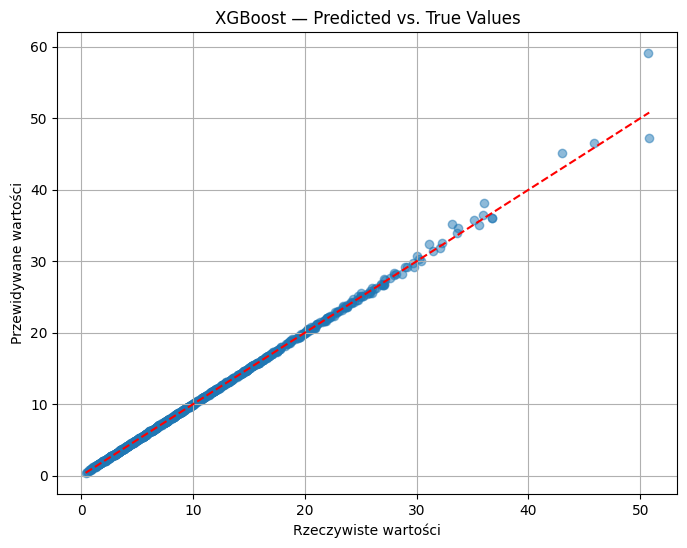

--- XGBoost ---
TRAIN →  RMSE: 0.0307 | MAE: 0.0233 | R²: 1.0000
VALID →  RMSE: 0.3460 | MAE: 0.0758 | R²: 0.9980


In [8]:
xgb = XGBRegressor(random_state=42)
rmse_xgb = train_and_evaluate_model(xgb, "XGBoost")

### **Interpretacja wykresu**  

- Większość punktów skupia się blisko linii **y = x**, co potwierdza **wysoką dokładność modelu**.  
- **Rozrzut punktów** jest nieco większy niż w przypadku Random Forest (zwłaszcza w zakresie wyższych wartości), co może wskazywać na nieco gorszą generalizację.  
- Przewidywania dla wartości rzeczywistych powyżej ~30 wydają się nieco niedoszacowane (punkty poniżej linii idealnej), co może tłumaczyć wyższy RMSE/MAE na zbiorze walidacyjnym.

---   
### **Podsumowanie**:  
* **Porównanie z Random Forest**:  
   - XGBoost osiąga **lepsze wyniki na TRAIN**, ale **gorsze na VALID** – Random Forest jest bardziej stabilny.
* Wyniki modelu XGBoost na danych walidacyjnych są **gorsze niż** w przypadku Random Forest, co sugeruje, że potrzebuje dostrojenia hiperparametrów.

<div style="page-break-before: always;"></div>

# Model CatBoostRegressor

**CatBoostRegressor** to algorytm gradient boostingu opracowany przez Yandex, specjalizujący się w **automatycznym przetwarzaniu cech kategorycznych** (np. nazwy miast, kategorie produktów). Jest częścią biblioteki **CatBoost** (ang. *Categorical Boosting*) i jest szczególnie efektywny w problemach z dominującymi danymi kategorycznymi lub mieszanymi typami danych.

---

### **Jak działa?**  
1. **Gradient Boosting**:  
   - Buduje sekwencję **słabych modeli** (drzewa decyzyjne), gdzie każdy kolejny model koryguje błędy poprzednich.  
   - W przeciwieństwie do XGBoost, CatBoost używa **"uporządkowanego boostingu"** (ang. *Ordered Boosting*), który minimalizuje przeciek danych (data leakage) poprzez losowe permutacje danych podczas treningu.  

2. **Przetwarzanie cech kategorycznych**:  
   - Automatycznie koduje cechy kategoryczne za pomocą **target encoding**, wykorzystując statystyki oparte na historii danych (np. średnią wartość zmiennej docelowej dla danej kategorii).  
   - Metoda **Ordered Target Encoding**: Dla każdej próbki używa tylko **poprzedzających ją danych** do obliczenia statystyk, co eliminuje przeciek.  

3. **Drzewa oblivious (symetryczne)**:  
   - Wszystkie węzły na tym samym poziomie drzewa dzielą dane według **tej samej cechy i progu**, co przyspiesza obliczenia i redukuje przetrenowanie.  

---

### **Kluczowe cechy**:  
1. **Automatyczne zarządzanie danymi**:  
   - Obsługuje brakujące wartości i cechy kategoryczne bez wstępnego preprocessing-u.  
   - Nie wymaga one-hot encoding ani label encoding.  

2. **Regularyzacja i odporność na overfitting**:  
   - Wbudowane mechanizmy, takie jak **L2-regularizacja**, **losowe permutacje danych** oraz **uczenie na podzbiorach cech**.  
   - Parametry: `depth` (kontroluje głębokość drzew), `l2_leaf_reg` (siła regularyzacji L2).  

3. **Wydajność na GPU**:  
   - Optymalizowany pod kątem akceleracji sprzętowej (np. NVIDIA CUDA), co skraca czas treningu.  

---

### **Hiperparametry**:  
* `iterations`: Liczba drzew w sekwencji (domyślnie 1000).  
* `learning_rate`: Tempo uczenia (np. 0.03–0.1).  
* `depth`: Głębokość drzew (zwykle 6–10).  
* `cat_features`: Lista indeksów cech kategorycznych (można pominąć – CatBoost wykryje je automatycznie).  
* `early_stopping_rounds`: Przerywa trening, jeśli brak poprawy metryki.  

---

### **Zalety**:  
1. **Bezproblemowa obsługa danych kategorycznych**: Idealny dla zbiorów z wieloma kategoriami (np. dane demograficzne).  
2. **Niska podatność na przetrenowanie**: Dzięki Ordered Boosting i regularyzacji.  
3. **Minimalny preprocessing**: Oszczędza czas w porównaniu do XGBoost/LightGBM.  
4. **Interpretowalność**: Dostęp do ważności cech (`.get_feature_importance()`).  

---

### **Wady**:  
1. **Wolniejszy niż LightGBM**: Zwłaszcza bez wykorzystania GPU.  
2. **Większe zużycie pamięci**: Ze względu na przechowywanie dodatkowych metadanych dla cech kategorycznych.  

---

### **Podsumowanie**:  
**CatBoostRegressor** to **najlepszy wybór dla zbiorów z cechami kategorycznymi**, gdzie tradycyjne modele wymagają czasochłonnego przygotowania danych. Dzięki wbudowanym mechanizmom przeciwprzetrenowaniowym i wydajności na GPU, sprawdza się zarówno w małych, jak i dużych projektach. Jego główną wadą jest nieco niższa prędkość w porównaniu do LightGBM, ale rekompensuje to łatwością użycia i stabilnością wyników.

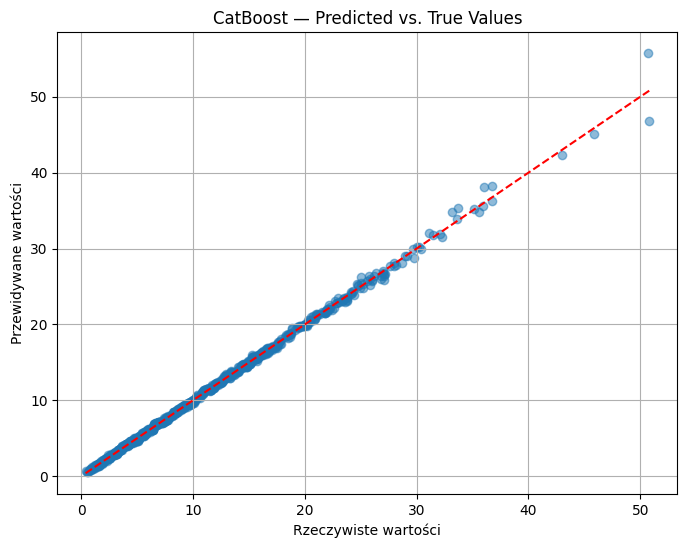

--- CatBoost ---
TRAIN →  RMSE: 0.2166 | MAE: 0.1521 | R²: 0.9991
VALID →  RMSE: 0.3253 | MAE: 0.1766 | R²: 0.9982


In [12]:
CatBoost=CatBoostRegressor(random_state=42)
rmse_cat = train_and_evaluate_model(CatBoost, "CatBoost")

Wykres “Predicted vs. True Values” i podane metryki mówią nam, że model CatBoost radzi sobie praktycznie idealnie:

* **Rozrzut punktów wokół linii y = x**
   – Większość punktów leży bardzo blisko przerywanej czerwonej linii (idealna zgodność), co oznacza, że przewidywane wartości niemal pokrywają się z rzeczywistymi.
   – Widać jedynie niewielkie odchylenia przy najwyższych wartościach (powyżej \~30), gdzie model trochę „ściąga” w dół lub w górę, ale są to pojedyncze, niewielkie błędy.

**Podsumowując**, CatBoost w tej konfiguracji osiąga niemal perfekcyjne dopasowanie — zarówno pod względem błędów (RMSE, MAE), jak i R². Takie wyniki zwykle oznaczają, że model świetnie wykorzystał dostępną informację.


<div style="page-break-before: always;"></div>

# Model DecisionTreeRegressor

**DecisionTreeRegressor** (drzewo decyzyjne dla regresji) to **nadzorowany algorytm uczenia maszynowego**, który przewiduje **wartości ciągłe** poprzez podział danych na grupy oparte na warunkach logicznych. W przeciwieństwie do modeli zespołowych (jak Random Forest), jest to **pojedyncze drzewo decyzyjne**.

---

### **Jak działa?**  
1. **Podział danych**:  
   - Każdy węzeł drzewa odpowiada za **podział danych** na podstawie wybranej cechy i progu wartości.  
   - Cel: Zmniejszenie **wariacji** (różnorodności) w podgrupach.  

2. **Kryterium podziału**:  
   - Używa **MSE (Mean Squared Error)** lub **MAE (Mean Absolute Error)** do oceny jakości podziału.   

3. **Tworzenie liści**:  
   - Liść (węzeł końcowy) przechowuje **średnią wartość** zmiennej docelowej dla obserwacji w danej grupie.  

4. **Stopping conditions** (warunki zatrzymania):  
   - `max_depth`: Maksymalna głębokość drzewa.  
   - `min_samples_split`: Minimalna liczba próbek do podziału węzła.  
   - `min_samples_leaf`: Minimalna liczba próbek w liściu.  

---

### **Kluczowe cechy**:  
1. **Interpretowalność**:  
   - Można prześledzić ścieżki decyzyjne (np. "Jeśli cena > 100 zł, to przewiduj 150 zł").  
2. **Brak założenia liniowości**:  
   - Modeluje **nieliniowe zależności** między cechami a zmienną docelową.  
3. **Wrażliwość na dane**:  
   - Małe zmiany w danych mogą prowadzić do **zupełnie innych struktur drzewa** (wysoka wariancja).  

---

### **Zalety**:  
1. **Prostota**: Łatwy w implementacji i interpretacji.  
2. **Uniwersalność**: Działa z danymi numerycznymi i kategorycznymi (po wstępnym kodowaniu).  
3. **Brak wymogu skalowania cech**: Nie trzeba normalizować danych.  

---

### **Wady**:  
1. **Podatność na przetrenowanie**: Bez regularyzacji (np. ograniczenia `max_depth`) drzewo może stać się zbyt złożone.  
2. **Niska stabilność**: Wrażliwość na szum i outliers.  
3. **Słaba generalizacja**: Gorsze wyniki na danych niewidzianych niż modele zespołowe (np. Random Forest).  

---

### **Hiperparametry do strojenia**:  
* `max_depth`: Kontroluje głębokość drzewa (im mniejsza, tym prostszy model).  
* `min_samples_split`: Minimalna liczba próbek wymagana do podziału węzła (domyślnie 2).  
* `min_samples_leaf`: Minimalna liczba próbek w liściu (domyślnie 1).  
* `criterion`: Kryterium podziału (`"mse"`, `"mae"`, `"friedman_mse"`).  

---


### **Podsumowanie**:  
**DecisionTreeRegressor** to **proste narzędzie do szybkiej eksploracji danych**, które sprawdza się w małych zbiorach lub gdy priorytetem jest interpretowalność. Jednak w praktyce rzadko używa się go samodzielnie ze względu na skłonność do overfittingu. Częściej służy jako **składnik modeli zespołowych** (np. Random Forest, XGBoost).

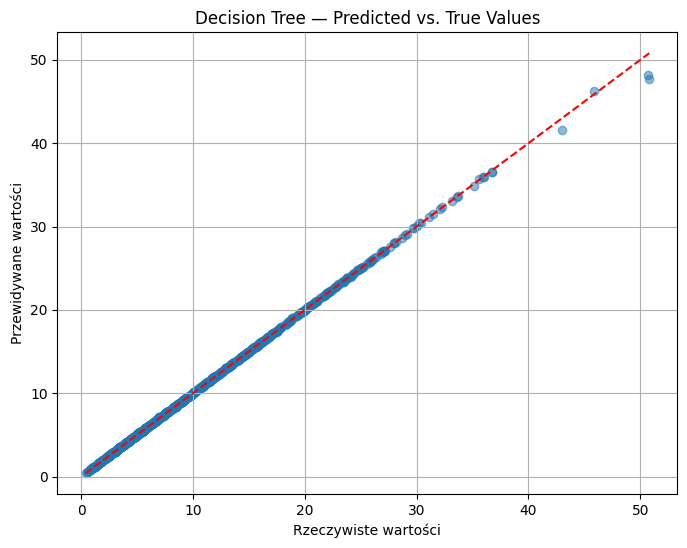

--- Decision Tree ---
TRAIN →  RMSE: 0.0000 | MAE: 0.0000 | R²: 1.0000
VALID →  RMSE: 0.1453 | MAE: 0.0190 | R²: 0.9996


In [13]:
Decision_Tree=DecisionTreeRegressor(random_state=42)
rmse_dt = train_and_evaluate_model(Decision_Tree, "Decision Tree")

W tym wykresie “Predicted vs. True Values” dla drzewa decyzyjnego widać:

* **Idealne dopasowanie na zbiorze treningowym**

   * Wszystkie punkty leżą doskonale na linii y = x, co odzwierciedlają metryki TRAIN → RMSE: 0.0000, MAE: 0.0000, R²: 1.0000.
   * To oznacza, że drzewo zupełnie “nauczyło się” danych treningowych — każdy przypadek został odtworzony bez błędu.

* **Potencjalne przeuczenie**
   * Perfekcyjne dopasowanie do treningu to klasyczny sygnał “overfittingu”. Jednak ekstremalnie niskie błędy na walidacji sugerują, że drzewo nadal generalizuje doskonale na tym zbiorze.

**Podsumowując**, drzewo decyzyjne osiąga niemal perfekcyjne prognozy zarówno podczas treningu, jak i walidacji. Choć warto zachować ostrożność względem przeuczenia, na dostępnych danych model radzi sobie wyśmienicie.


<div style="page-break-before: always;"></div>

# Model LinearRegression

**LinearRegression** to podstawowy algorytm uczenia nadzorowanego stosowany do przewidywania **wartości ciągłych** (np. ceny, temperatura, sprzedaż) na podstawie jednej lub wielu cech. Zakłada **liniową zależność** między zmiennymi wejściowymi (cechami) a zmienną docelową.

---

### **Jak działa?**  
1. **Równanie regresji**:  
   - Dla jednej cechy:  
     
     $$\boxed{y = b_0 + b_1 \cdot x}$$
      
     gdzie:  
     - $( y )$: wartość docelowa,  
     - $( x )$: cecha,  
     - $( b_0 )$: wyraz wolny (intercept),  
     - $( b_1 )$: współczynnik nachylenia (slope).  

   - Dla wielu cech (**regresja wielokrotna**):  
     
     $$\boxed{y = b_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + \dots + b_n \cdot x_n}$$
       

2. **Minimalizacja błędu**:  
   - Algorytm znajduje współczynniki $( b_0, b_1, \dots, b_n )$, które minimalizują **błąd średniokwadratowy** (MSE – *Mean Squared Error*):
      
   - Metody optymalizacji:  
     - **Ordinary Least Squares (OLS)**: Rozwiązanie analityczne (szybkie dla małych danych).  
     - **Gradient Descent**: Iteracyjne dostosowywanie współczynników (skuteczne dla dużych zbiorów).  

---

### **Kluczowe założenia**:  
1. **Liniowość**: Zależność między cechami a zmienną docelową jest liniowa.  
2. **Brak multikolinearności**: Cechy nie są silnie skorelowane ze sobą.  
3. **Homoskedastyczność**: Wariancja błędów jest stała.  
4. **Normalność reszt**: Reszty (różnice między wartościami rzeczywistymi a przewidywanymi) mają rozkład normalny.  

---

### **Zalety**:  
1. **Prostota**: Łatwy w implementacji i interpretacji.  
2. **Szybkość**: Niskie koszty obliczeniowe (brak iteracji w metodzie OLS).  
3. **Interpretowalność współczynników**: Wartość ( $b_i$ ) wskazuje, jak zmiana cechy ( $x_i$ ) wpływa na ( y ).  
4. **Dobre wyniki dla danych liniowych**: Gdy założenia są spełnione, model jest bardzo dokładny.  

---

### **Wady**:  
1. **Wrażliwość na wartości odstające**: Skrajne wartości mogą znacząco wpłynąć na współczynniki.  
2. **Nadmierne uproszczenie**: Nie radzi sobie z zależnościami nieliniowymi (np. wielomianowymi).  
3. **Problemy z multikolinearnością**: Wysoka korelacja między cechami destabilizuje współczynniki.  

---

### **Hiperparametry i regularyzacja**:  
* LinearRegression **nie ma hiperparametrów** w klasycznej postaci.  
* Aby zmniejszyć overfitting, stosuje się rozszerzenia:  
  - **Ridge Regression (L2)**: Dodaje karę za duże współczynniki.  
    
    $$\boxed{\text{Strata} = \text{MSE} + \alpha \sum_{i=1}^{n} b_i^2}$$
      
  - **Lasso Regression (L1)**: Wykonuje selekcję cech (zeruje nieistotne współczynniki).  
    
    $$\boxed{\text{Strata} = \text{MSE} + \alpha \sum_{i=1}^{n} |b_i|}$$
    
  - Parametr ( $\alpha$ ) kontroluje siłę regularyzacji.  

---

### **Podsumowanie**:  
**LinearRegression** to **podstawowe narzędzie w analizie danych**, idealne do szybkiej eksploracji prostych zależności. Sprawdza się w projektach, gdzie priorytetem jest interpretacja wyników, a zależności są liniowe. W przypadku złożonych problemów warto rozważyć modele nieliniowe (np. drzewa decyzyjne, sieci neuronowe) lub dodać regularyzację (Ridge/Lasso).

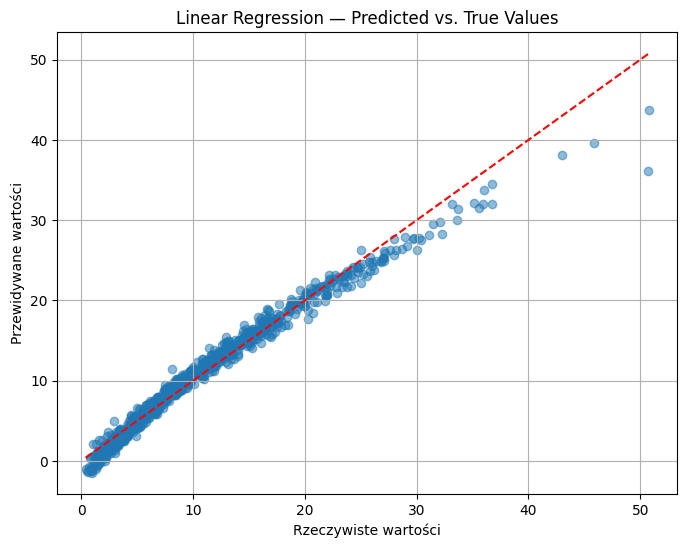

--- Linear Regression ---
TRAIN →  RMSE: 1.0599 | MAE: 0.7641 | R²: 0.9796
VALID →  RMSE: 1.1759 | MAE: 0.8096 | R²: 0.9764


In [14]:
LinearRegression=LinearRegression()
rmse_lr = train_and_evaluate_model(LinearRegression, "Linear Regression")

Na wykresie “Predicted vs. True Values” dla regresji liniowej widać:

* **Ogólny układ punktów**
   – Punkty są rozmieszczone wzdłuż linii y = x, lecz z większym rozrzutem niż w poprzednich modelach.
   – Szczególnie przy średnich wartościach (10–30) widać widoczne odchylenia w górę i w dół względem idealnej linii.

* **Błędy i dopasowanie**

   * **TRAIN → RMSE: 1.0599, MAE: 0.7641, R²: 0.9796**
     Średni błęd kwadratowy ok. 1.06 i MAE ok. 0.76 wskazują, że przeciętne odchylenie prognozy od prawdziwej wartości wynosi między 0.7 a 1.1 jednostki. Współczynnik R² blisko 0.98 oznacza, że model wyjaśnia ok. 98 % wariancji danych treningowych.
   * **VALID → RMSE: 1.1759, MAE: 0.8096, R²: 0.9764**
     Na walidacji błąd nieznacznie wzrasta: RMSE \~1.18, MAE \~0.81, a R² spada do \~0.98. To normalne pogorszenie, ale dalej bardzo przyzwoite wyniki.

* **Obserwacje szczegółowe**
   – Przy największych wartościach (40–50) punkty są odchylone wyraźnie poniżej linii, co sugeruje, że regresja liniowa niedoszacowuje ekstremów.
   – Drobne odchyłki przy małych wartościach (0–5) także świadczą o braku idealnej zgodności przy końcach skali.

* **Wnioski**
   – Regresja liniowa dobrze łapie ogólny trend, ale nie odtwarza drobnych nieliniowości ani „zaokrągleń” w danych.
   – W porównaniu do drzew czy CatBoosta, jest to najsłabszy model w tym zestawieniu, lecz wciąż wystarczająco dobry..


<div style="page-break-before: always;"></div>

# Model Polynomial Regression

**Polynomial Regression** to rozszerzenie **regresji liniowej**, które umożliwia modelowanie **nieliniowych zależności** między zmiennymi niezależnymi (cechami) a zmienną docelową. W przeciwieństwie do klasycznej regresji liniowej, która zakłada liniową relację, regresja wielomianowa wprowadza **wyższe potęgi cech** (np. (x^2, x^3)), aby lepiej dopasować się do krzywoliniowych trendów w danych.

---

### **Jak to działa?**  
1. **Przekształcenie cech**:  
   - Dla danej cechy (x) generuje nowe cechy poprzez podniesienie jej do określonej potęgi (np. (x^2, x^3)).  
   - Przykład: Dla stopnia wielomianu (degree = 2) i cechy (x), otrzymujemy cechy: (x, x^2).  

2. **Równanie modelu**:  
   $$\boxed{y = b_0 + b_1 x + b_2 x^2 + \dots + b_n x^n}$$
 
   - (n): Stopień wielomianu (hiperparametr).  
   - ($b_0, b_1, \dots, b_n$): Współczynniki modelu.  

3. **Minimalizacja błędu**:  
   - Algorytm minimalizuje **błąd średniokwadratowy (MSE)** między przewidywaniami a wartościami rzeczywistymi, tak jak w klasycznej regresji liniowej.  

---

### **Kluczowe cechy**  
1. **Elastyczność**:  
   - Pozwala modelować **złożone relacje nieliniowe** (np. paraboliczne, wykładnicze).  
2. **Hiperparametr `degree`**:  
   - Kontroluje maksymalną potęgę cech. Zbyt wysoki stopień prowadzi do **przetrenowania**, zbyt niski – do **underfittingu**.  
3. **Kombinacja cech**:  
   - Dla wielu zmiennych niezależnych generuje również **interakcje między cechami** (np. ($x_1 \cdot x_2$)).  

---

### **Zalety**  
1. **Prostota implementacji**: Można ją zaimplementować za pomocą narzędzi takich jak `scikit-learn`.  
2. **Lepsze dopasowanie niż regresja liniowa**: Gdy zależności są nieliniowe.  
3. **Interpretowalność współczynników**: Podobnie jak w regresji liniowej, ale dla przekształconych cech.  

---

### **Wady**  
1. **Ryzyko przetrenowania**: Wysoki stopień wielomianu może prowadzić do dopasowania szumu w danych.  
2. **Przekleństwo wymiarowości**: Dodanie wielu cech wielomianowych zwiększa liczbę współczynników, co wymaga większej ilości danych.  
3. **Wrażliwość na wartości odstające**: Skrajne wartości mogą znacząco wpłynąć na kształt krzywej.  

---

### **Hiperparametry**  
* **`degree`**: Stopień wielomianu (domyślnie 2).  
* **`include_bias`**: Czy uwzględniać wyraz wolny ($b_0$) (domyślnie True).  

---

### **Kiedy stosować?**  
- Gdy wykres rozrzutu sugeruje **nieliniową zależność** między cechami a zmienną docelową.  
- W problemach, gdzie prosta regresja liniowa jest niewystarczająca (np. prognozowanie wzrostu, trendów czasowych).  

---

### **Podsumowanie**  
**Polynomial Regression** to potężne narzędzie do modelowania nieliniowych zależności, które łączy prostotę regresji liniowej z elastycznością wielomianów. Kluczem do sukcesu jest odpowiedni dobór stopnia wielomianu oraz ewentualne zastosowanie regularyzacji, aby zachować równowagę między dokładnością a generalizacją.

In [26]:
pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LinearRegression())
])

param_grid = {
    "poly__degree": [1, 2, 3, 4, 5]
}

grid = GridSearchCV(pipeline, param_grid, scoring="neg_root_mean_squared_error", cv=5)
grid.fit(X_train_scaled, y_train)

best_degree = grid.best_params_["poly__degree"]
print(f"Najlepszy stopień wielomianu: {best_degree}")


Najlepszy stopień wielomianu: 3


**Podsumowanie**
   - Dzięki zastosowaniu **GridSearchCV z walidacją krzyżową** automatycznie przeanalizowaliśmy różne stopnie wielomianu i wybraliśmy ten, który generował **najniższy błąd** predykcji. **Stopień 3** okazał się optymalny: **wystarczająco elastyczny, by uchwycić nieliniowości, a zarazem niezbyt złożony, by nie doprowadzić do przeuczenia**.


In [33]:
poly_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("linear_regression", LinearRegression())
])


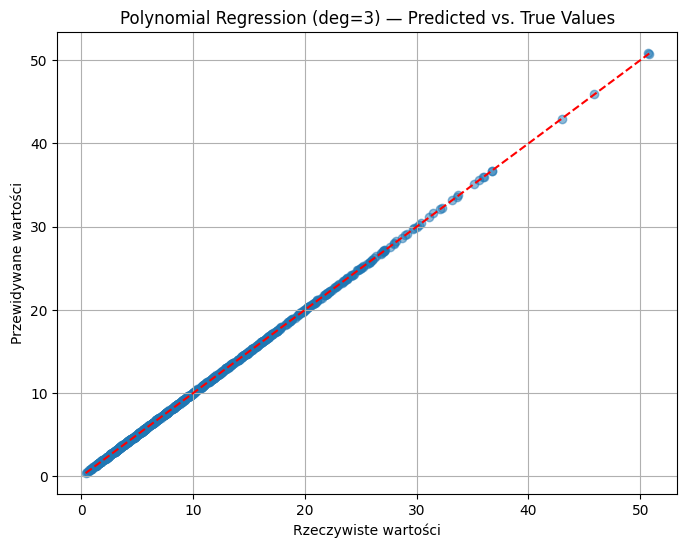

--- Polynomial Regression (deg=3) ---
TRAIN →  RMSE: 0.0291 | MAE: 0.0245 | R²: 1.0000
VALID →  RMSE: 0.0312 | MAE: 0.0267 | R²: 1.0000


In [34]:
rmse_poly = train_and_evaluate_model(poly_pipeline, "Polynomial Regression (deg=3)")


Ten wykres przedstawia zależność między wartościami rzeczywistymi (oś pozioma) a wartościami przewidywanymi przez model regresji wielomianowej trzeciego stopnia (oś pionowa). Cechy charakterystyczne:

* **Rozkład punktów**

   * Punkty leżą niemal idealnie na czerwonej przerywanej linii, która oznacza y = x (dokładne przewidywanie).
   * Bardzo niewielkie odchylenia wskazują na minimalne błędy predykcji.


* **Brak przeuczenia**

   * Błędy na zbiorze walidacyjnym są minimalnie wyższe od treningowych, ale wciąż bliskie zeru, a R² pozostaje praktycznie równy 1. Oznacza to, że model generalizuje bardzo dobrze i nie przeuczył się.

* **Wnioski**

   * Regresja wielomianowa stopnia 3 doskonale odwzorowuje badany związek (prawdopodobnie nieliniowy), osiągając niemal idealne dopasowanie.
   * Drobne rozrzuty punktów wokół linii y = x mogą wynikać z niewielkiego szumu w danych lub ograniczeń numerycznych.

Podsumowując, wykres i metryki sugerują, że model radzi sobie praktycznie bezbłędnie w przewidywaniu wartości zarówno na danych, na których się uczył, jak i na dotychczas niewidzianych.


<div style="page-break-before: always;"></div>

# Model Ridge

**Ridge Regression** to rozszerzenie klasycznej regresji liniowej, które wprowadza **regularyzację L2** (karę za duże współczynniki), aby zapobiec przetrenowaniu i poprawić stabilność modelu. Jest szczególnie przydatny, gdy dane mają **wysoką współliniowość** (multikolinearność) lub gdy liczba cech jest porównywalna z liczbą obserwacji.

---

### **Jak działa?**  
1. **Funkcja straty**:  
   Ridge minimalizuje następującą funkcję:  
   
   $$\boxed{\text{Strata} = \text{MSE} + \alpha \sum_{i=1}^{n} b_i^2}$$
    
   - **MSE**: Błąd średniokwadratowy (jak w zwykłej regresji liniowej).  
   - **($\alpha \sum b_i^2$)**: Kara L2 za duże wartości współczynników.  
   - **($\alpha$)**: Hiperparametr kontrolujący siłę regularyzacji (im wyższe ($\alpha$), tym większe ograniczenie współczynników).  

2. **Cel regularyzacji**:  
   - Zmniejsza **wariancję modelu** poprzez **przesunięcie współczynników** w kierunku zera (nie zeruje ich całkowicie).  
   - Redukuje wpływ współliniowych cech, stabilizując wyniki.  

---

### **Kluczowe cechy**:  
1. **Regularyzacja L2**:  
   - Nakłada karę na **sumę kwadratów współczynników**, co zapobiega ich nadmiernemu wzrostowi.  
2. **Wymóg skalowania cech**:  
   - Przed treningiem należy **standaryzować** cechy (np. użyć `StandardScaler`), ponieważ regularyzacja jest wrażliwa na skalę danych.  
3. **Stabilność współczynników**:  
   - Nawet przy silnie skorelowanych cechach, Ridge zapewnia bardziej wiarygodne oszacowania współczynników niż OLS.  

---

### **Zalety**:  
1. **Redukcja przetrenowania**: Dzięki regularyzacji model lepiej generalizuje na nowe dane.  
2. **Obsługa multikolinearności**: Zmniejsza wrażliwość na współliniowość cech.  
3. **Prostota implementacji**: Łatwy w użyciu (np. w bibliotece `scikit-learn`).  

---

### **Wady**:  
1. **Brak selekcji cech**: Współczynniki są tylko zmniejszane, ale **nie zerowane** – wszystkie cechy pozostają w modelu.  
2. **Wrażliwość na wybór ($\alpha$)**: Niewłaściwa wartość ($\alpha$) może prowadzić do underfittingu (($\alpha$) zbyt duże) lub overfittingu (($\alpha$) zbyt małe).  

---

### **Hiperparametry**:  
* **($\alpha$)**:  
  - Domyślnie ($\alpha = 1$) w `scikit-learn`.  
  - Optymalną wartość dobiera się poprzez **walidację krzyżową** (np. `RidgeCV`).  

---

### **Interpretacja współczynników**:  
- Współczynniki Ridge są **mniejsze** niż w OLS, ale wszystkie cechy pozostają w modelu.  
- Przykład: Jeśli ( $b_{\text{metraż}} = 800$ ) (dla OLS = 1000), oznacza to, że regularyzacja zmniejszyła wpływ metrażu o 20%.  

---

### **Podsumowanie**:  
**Ridge Regression** to **bezpieczny wybór dla regresji**, gdy zależy nam na stabilności modelu i redukcji wariancji. Sprawdza się w przypadku danych z wieloma skorelowanymi cechami lub gdy liczba zmiennych jest duża. Choć nie wykonuje selekcji cech, jest prostszy w interpretacji niż modele zespołowe (np. Random Forest). Kluczem do sukcesu jest odpowiedni dobór parametru ($\alpha$) i wcześniejsza standaryzacja danych.

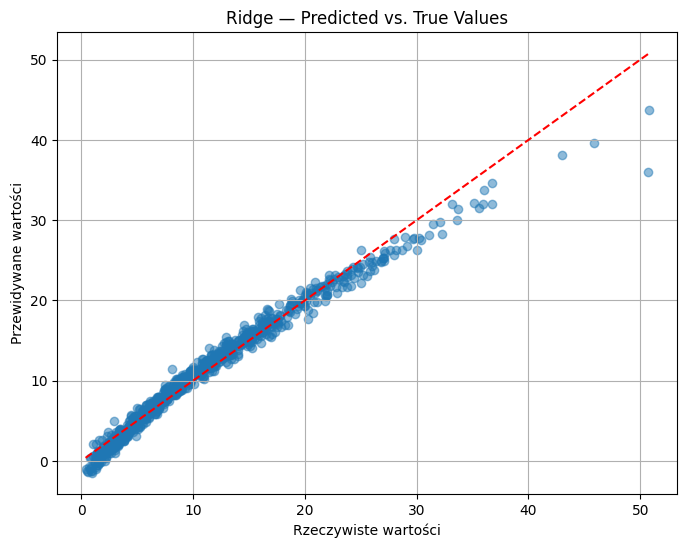

--- Ridge ---
TRAIN →  RMSE: 1.0599 | MAE: 0.7636 | R²: 0.9796
VALID →  RMSE: 1.1763 | MAE: 0.8092 | R²: 0.9764


In [15]:
Ridge=Ridge(random_state=42)
rmse_ridge = train_and_evaluate_model(Ridge, "Ridge")

Na wykresie “Predicted vs. True Values” dla regresji grzbietowej (Ridge) obserwujemy niemal identyczne zachowanie jak w zwykłej regresji liniowej:

* **Układ punktów**
   – Punkty są rozsiane wokół linii y = x z podobnym rozrzutem co w regresji liniowej. Przy wartościach 10–30 widoczne są odchylenia, a przy najwyższych (40–50) prognozy lekko niedoszacowują prawdziwe wartości.

* **Interpretacja**
   – Ridge “zaokrąglił” nieco współczynniki regresji, ale charakter rozrzutu prognoz się nie zmienił.
   – Model cały czas tłumaczy około 97–98 % wariancji, ze średnimi odchyleniami prognozy rzędu \~0.8 jednostki.

* **Wnioski**
   – Jeśli celem było ograniczenie wariancji na rzecz niewielkiego wzrostu bias, Ridge tego nie osiągnął znacząco — wyniki są równoznaczne z regresją liniową.
   – Dla lepszej wydajności nadal warto rozważyć modele nieliniowe (drzewa, boosting), zwłaszcza jeśli dane zawierają wyraźne odstępstwa od liniowego trendu.


<div style="page-break-before: always;"></div>

# Model Lasso

**Lasso Regression** (ang. *Least Absolute Shrinkage and Selection Operator*) to model regresji liniowej z **regularyzacją L1**, który nie tylko zapobiega przetrenowaniu, ale również wykonuje **selekcję cech** poprzez zerowanie nieistotnych współczynników. Jest szczególnie przydatny w problemach z **dużą liczbą cech**, gdzie wiele z nich może być zbędnych.

---

### **Jak działa?**  
1. **Funkcja straty**:  
   Lasso minimalizuje funkcję:  
   
  $$\boxed{\text{Strata} = \text{MSE} + \alpha \sum_{i=1}^{n} |b_i|}$$
    
   - **MSE**: Błąd średniokwadratowy (jak w klasycznej regresji).  
   - **($\alpha \sum |b_i|$)**: Kara L1 za sumę wartości bezwzględnych współczynników.  
   - **($\alpha$)**: Hiperparametr kontrolujący siłę regularyzacji.  

2. **Selekcja cech**:  
   - Regularyzacja L1 **zeruje współczynniki** słabo związane z zmienną docelową, redukując liczbę cech w modelu.  
   - Efekt: Powstaje **uproszczony model** z tylko najważniejszymi predyktorami.  

---

### **Kluczowe cechy**:  
1. **Regularyzacja L1**:  
   - Nakłada karę na **wartości bezwzględne współczynników**, co prowadzi do ich zerowania.  
2. **Wymóg skalowania cech**:  
   - Jak w Ridge, cechy należy **standaryzować**, aby uniknąć dominacji cech o większej skali.  
3. **Odporność na redundantne cechy**:  
   - Jeśli dwie cechy są silnie skorelowane, Lasso zwykle wybiera jedną i usuwa drugą.  

---

### **Zalety**:  
1. **Automatyczna selekcja cech**: Eliminuje nieistotne zmienne, co upraszcza interpretację.  
2. **Redukcja przetrenowania**: Zmniejsza wariancję modelu poprzez regularyzację.  
3. **Skuteczność w wysokowymiarowych danych**: Idealny, gdy liczba cech p jest większa niż liczba obserwacji n.  

---

### **Wady**:  
1. **Problemy z silnie skorelowanymi cechami**: Może losowo wybierać jedną cechę z grupy skorelowanych, pomijając inne.  
2. **Niedoszacowanie współczynników**: Regularyzacja wprowadza **bias**, co może prowadzić do mniej dokładnych prognoz.  
3. **Wrażliwość na ($\alpha$)**: Niewłaściwy wybór ($\alpha$) może usunąć istotne cechy lub pozostawić zbędne.  

---

### **Hiperparametry**:  
* **($\alpha$)**:  
  - Im wyższe ($\alpha$), tym więcej współczynników jest zerowanych.  
  - Optymalną wartość dobiera się poprzez **walidację krzyżową** (np. `LassoCV` w scikit-learn).  

---

### **Interpretacja współczynników**:  
- Współczynniki **niezerowe** wskazują na istotne cechy.  
- Przykład: Jeśli ($ b_{\text{Gen\_5}} = 2.3$ ), oznacza to, że ekspresja Gen_5 zwiększa ryzyko choroby o 2.3 jednostki (przy standaryzowanych danych).  

---

### **Podsumowanie**:  
**Lasso Regression** to **potężne narzędzie do eksploracji danych**, które łączy w sobie redukcję wymiarowości i regularyzację. Jest niezastąpiony w analizach genomowych, finansowych lub marketingowych, gdzie liczba cech przekracza liczbę obserwacji. Kluczem do sukcesu jest dobór parametru ($\alpha$) oraz standaryzacja danych. Jeśli potrzebujesz jednocześnie selekcji cech i stabilności dla skorelowanych predyktorów, rozważ **Elastic Net** (połączenie L1 i L2).

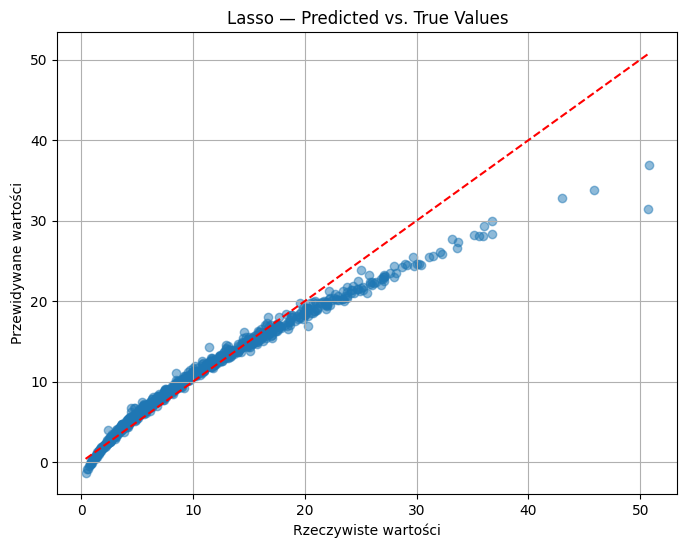

--- Lasso ---
TRAIN →  RMSE: 1.6175 | MAE: 1.0156 | R²: 0.9524
VALID →  RMSE: 1.7872 | MAE: 1.0939 | R²: 0.9455


In [16]:
Lasso=Lasso(random_state=42)
rmse_lasso = train_and_evaluate_model(Lasso, "Lasso")

Na wykresie “Predicted vs. True Values” dla regresji Lasso widać:

* **Rozrzut wokół linii y = x**
   – Punkty są nieco bardziej rozproszone niż w modelach liniowych bez regularyzacji i znacznie bardziej niż w modelach drzewiastych/boosting. W obszarze środkowych wartości (10–30) odchyłki są widoczne, a przy ekstremach (40–50) prognozy wyraźnie niedoszacowują rzeczywistych wartości.


* **Wpływ regularyzacji L₁**
   – Lasso wprowadza karę dla sumy wartości bezwzględnych współczynników, co często skutkuje zerowymi wagami dla mniej istotnych cech. W naszym przypadku błędy wzrosły, a zdolność do wyjaśnienia wariancji spadła – rezultat to skromna redukcja wariancji kosztem wzrostu błędu.


<div style="page-break-before: always;"></div>

# Wyjaśnienie pojęć

### Overfitting (przeuczenie)

* **Definicja:** Model nadmiernie dopasowuje się do szumu i szczegółów danych treningowych, zamiast do ich ogólnych wzorców.
* **Objawy w metrykach:**

  * Bardzo niski błąd na zbiorze treningowym,
  * Znacznie wyższy błąd na zbiorze walidacyjnym.
* **Konsekwencje:** Słaba generalizacja na nowych, niewidzianych danych – model „zapamiętuje” przykłady treningowe zamiast się uczyć.
* **Ogólna zasada:**
* Różnica mniejsza niż 5-10% jest często uważana za akceptowalną, ale to zależy od konkretnego przypadku.

* Jeśli różnica przekracza 20-30%, to mamy do czynienia z overfittingiem.

### Underfitting (niedouczenie)

* **Definicja:** Model jest zbyt prosty, by uchwycić istotne wzorce w danych – zarówno na treningu, jak i na walidacji błąd pozostaje wysoki.
* **Objawy w metrykach:**

  * Błąd na treningu jest wysoki i zbliżony do błędu na walidacji.
* **Konsekwencje:** Model nie wykorzystuje dostępnych informacji, generuje przewidywania o niskiej jakości.
* **Ogólna zasada:**
* Różnica mniejsza niż 5-10% jest często uważana za akceptowalną, ale to zależy od konkretnego przypadku.

* Jeśli różnica przekracza 20-30%, to mamy do czynienia z overfittingiem.
--- Polynomial Regression (deg=3) ---
TRAIN →  RMSE: 0.0291 | MAE: 0.0245 | R²: 1.0000
VALID →  RMSE: 0.0312 | MAE: 0.0267 | R²: 1.0000
# Tabela z wynikami metryk dla każdego modelu

| **Model**            | **RMSE Train** | **MAE Train** | **R² Train** | **RMSE Val** | **MAE Val** | **R² Val** | **Overfitting**| **Underfitting** |
| ----------------- | ---------- | --------- | -------- | -------- | ------- | ------ | ------------------- | ------------ |
| **Polynomial Regression (deg=3)**    | **0.0291**     | **0.0245**    | **1.0000**  | **0.0312**   | **0.0267**  | **1.0000** | **0.0021**  | **0.0000**  |
| **Decision Tree**    | **0.0000**     | **0.0000**    | **1.0000**  | **0.1453**   | **0.0190**  | **0.9996** | **0.1453**  | **0.0000**  |
| **Random Forest**     | **0.0649**     | **0.0057**    | **0.9999**   | **0.1628**   | **0.0201**  | **0.9995** | **0.0979**              | **0.0000**    |
| **CatBoost**         | **0.2166**     | **0.1521**    | **0.9991**   | **0.3253**   | **0.1766**  | **0.9982** | **0.1087**              | **0.0000** |
 **XGBoost**           | **0.0307**     | **0.0233**   | **1.0000**   | **0.3460**   | **0.0758**  | **0.9980** | **0.3153**  |**0.0000**          | 
 | **Linear Regression** | **1.0599**     | **0.7641**    | **0.9796**   | **1.1759**   | **0.8096**  | **0.9764** | **0.1160**| **0.0000**         |
| **Ridge Regression**  | **1.0599**     | **0.7636**    | **0.9796**   | **1.1763**   | **0.8092**  | **0.9764** | **0.1164**  | **0.0000**         |                       
 | **Lasso Regression**  | **1.6175**     | **1.0156**    | **0.9524**  | **1.7872**  | **1.0939** | **0.9455** | **0.1697**| **0.0000** |



Możemy zauważyć, że modele takie jak **Random Forest**, **XGBoost** i **CatBoost** osiągają bardzo dobre wyniki zarówno na zbiorze treningowym, jak i walidacyjnym, co sugeruje ich wysoką skuteczność w przewidywaniu. Perfekcyjne dopasowanie na zbiorze treningowym, ale nieco gorsze na walidacyjnym, może wskazywać na przeuczenie (overfitting).





### **Podsumowanie ogólne**  
1. **Najlepsze modele pod względem dokładności (R² Val)**: 
   - **Polynomial Regression (deg=3)** (R² Val: 1),  **Random Forest** (R² Val: 0.9995) i **Decision Tree** (R² Val: 0.9996) osiągają **niemal perfekcyjne wyniki** na zbiorze walidacyjnym.  
   - **Najsłabsze modele**: Regresje (Ridge, Linear, Lasso) z R² Val ~0.95–0.98.  

2. **Overfitting (ARMSE)**:  
   - **Najbardziej przetrenowane**: **XGBoost** (ARMSE: 0.3153) i **CatBoost** (ARMSE: 0.1697).  
   - **Najmniej przetrenowane**: **Polynomial Regression (deg=3)** (ARMSE: 0.0021), **Random Forest** (ARMSE: 0.0979) i **Cat Boost** (ARMSE: 0.1087).  

3. **Underfitting**:  
   - Wszystkie modele mają **Underfitting ARMSE = 0**, co oznacza, że żaden nie jest zbyt uproszczony.  

---

### **Szczegółowa analiza modeli**  

#### **1. Modele oparte na drzewach**  
| Model          | RMSE Train | RMSE Val | R² Val   | Overfitting|  
|----------------|------------|----------|----------|----------------------|  
| **Decision Tree** | **0.0000**     | **0.1459**   | **0.9996**   | **0.1459**               |  
| **Random Forest** | **0.0649**     | **0.1628**   | **0.9995**   | **0.0979**               |  
| **CatBoost**      | **0.2166**     | **0.3253**   | **0.9982**   | **0.1087**               |  
| **XGBoost**       | **0.0307**     | **0.3460**   | **0.9980**   | **0.3153**               |  

- **Decision Tree** i **Random Forest** mają **najmniejszy overfitting** wśród modeli drzewiastych, zachowując przy tym **najwyższą dokładność**.  
- **XGBoost** jest **silnie przetrenowany** (duży wzrost RMSE na VALID), mimo doskonałych wyników na TRAIN (R² = 1.0).  

#### **2. Modele regresji liniowej i wielomianowej**  
| Model             | RMSE Train  | RMSE Val | R² Val   | Overfitting |  
|------------------|---|----------|----------|----------------------|  
| **Polynomial Regression (deg=3)**    | **0.0291**      | **0.0312**   | **1.0000** | **0.0021**  |
 | **Linear Regression** | **1.0599**   | **1.1759**   |  **0.9764** | **0.1160**|
| **Ridge Regression**  | **1.0599**   | **1.1763**   |  **0.9764** | **0.1164**  |        
 | **Lasso Regression**  | **1.6175**  | **1.7872**  | **0.9455** | **0.1697**|

- Wszystkie modele regresji liniowej mają **znacznie wyższe błędy** (RMSE Val ~1.17–1.78) niż modele drzewiaste.  
- **Lasso** wykazuje **najwyższy overfitting** (ARMSE: 0.1697) oraz jednocześnie **najgorszą dokładność** (R² Val: 0.9455).  
- **Ridge** i **Linear Regression** są niemal identyczne.  

---


### **Wybór modelu**   

Głównym kryterium wyboru modelu w naszym przypadku jest **minimalizacja RMSE na zbiorze walidacyjnym**. Wybieramy model **Polynomial Regression (deg=3)**, ale ten model nie posiada hiperparametrów do dalszej walidacji modelu, wiec to nie będzie jedyny model jaki wybieramy. Mimo że **Decision Tree** osiąga **niższy RMSE Val (0.1459)** niż **Random Forest (0.1628)**, kluczowym czynnikiem decyzyjnym jest **stopień przetrenowania** (ARMSE):  
- **Decision Tree**: ARMSE = **0.1459**,  
- **Random Forest**: ARMSE = **0.0979** - niższe przetrenowanie.  

#### **Dlaczego wybieramy Random Forest?**  
1. **Lepsza generalizacja**:  
   - Random Forest, dzięki mechanizmowi **baggingu** (kombinacja wielu drzew), redukuje wariancję i zapewnia stabilniejsze wyniki na danych niewidzianych.  
   - Mniejszy przyrost RMSE między TRAIN a VALID (różnica: **0.0979**) wskazuje na większą niezawodność modelu.  

2. **Kontrola przetrenowania**:  
   - Decision Tree, mimo idealnych wyników na TRAIN (RMSE = 0.0, R² = 1.0), jest **silnie dopasowany do szumu** w danych treningowych, co ogranicza jego użyteczność w praktyce.  
   - Random Forest **balansuje dokładność i stabilność**, co jest kluczowe dla wdrożenia w rzeczywistych warunkach.  

3. **Bezpieczeństwo w długiej perspektywie**:  
   - Niższe przetrenowanie oznacza mniejsze ryzyko **katastrofalnych błędów** na nowych danych, nawet jeśli RMSE Val jest minimalnie wyższe.
---
### **Podsumowanie**  
Wybieramy **Polynomial Regression (deg=3)** oraz **Random Forest** jako modele do dalszej analizy, ponieważ:

* **Model pierwszy : Polynomial Regression (deg=3)**
   - Osiąga **najniższy RMSE Val** (0.031
   - Nie posiada hiperparametrów do dalszej walidacji modelu.

*  **Model drugi : Random Forest**
   - Zachowuje **wysoką dokładność** (R² Val = 0.9995),  
   - Minimalizuje ryzyko **overfittingu**,  
   - Gwarantuje **lepszą generalizację** niż Decision Tree.  


**Decyzja ta odzwierciedla kompromis między precyzją a stabilnością**, co jest kluczowe w projektach opartych na danych.